# How to Forecast a Time Series with Python

Wouldn't it be nice to know the future? This is the notebook that relates to the blog post on medium. Please check the blog for visualizations and explanations, this notebook is really just for the code :)


## Processing the Data

Let's explore the Industrial production of electric and gas utilities in the United States, from the years 1985-2018, with our frequency being Monthly production output.

You can access this data here: https://fred.stlouisfed.org/series/IPG2211A2N

This data measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

In [1]:
%matplotlib inline
import pandas as pd
data = pd.read_csv("Electric_Production.csv",index_col=0)
data.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


Right now our index is actually just a list of strings that look like a date, we'll want to adjust these to be timestamps, that way our forecasting analysis will be able to interpret these values:

In [2]:
data.index

Index([u'1985-01-01', u'1985-02-01', u'1985-03-01', u'1985-04-01',
       u'1985-05-01', u'1985-06-01', u'1985-07-01', u'1985-08-01',
       u'1985-09-01', u'1985-10-01',
       ...
       u'2017-04-01', u'2017-05-01', u'2017-06-01', u'2017-07-01',
       u'2017-08-01', u'2017-09-01', u'2017-10-01', u'2017-11-01',
       u'2017-12-01', u'2018-01-01'],
      dtype='object', name=u'DATE', length=397)

In [3]:
data.index = pd.to_datetime(data.index)

In [4]:
data.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [5]:
data.index

DatetimeIndex(['1985-01-01', '1985-02-01', '1985-03-01', '1985-04-01',
               '1985-05-01', '1985-06-01', '1985-07-01', '1985-08-01',
               '1985-09-01', '1985-10-01',
               ...
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
               '2017-12-01', '2018-01-01'],
              dtype='datetime64[ns]', name=u'DATE', length=397, freq=None)

Let's first make sure that the data doesn't have any missing data points:

In [6]:
data[pd.isnull(data['IPG2211A2N'])]

,IPG2211A2N
DATE,


Let's also rename this column since its hard to remember what "IPG2211A2N" code stands for:

In [7]:
data.columns = ['Energy Production']

In [8]:
data.head()

,Energy Production
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


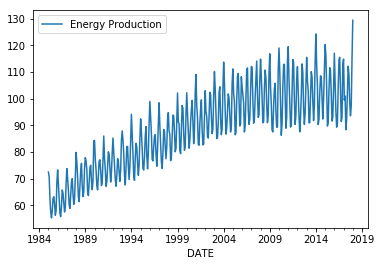

In [9]:
import matplotlib.pyplot as plt
data.plot()
plt.show()

In [10]:
from pyramid.arima import auto_arima

**he AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [11]:
stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True) 

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1782.527, BIC=1802.280, Fit time=5.687 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=2012.117, BIC=2020.018, Fit time=0.055 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1942.042, BIC=1957.844, Fit time=0.687 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1837.289, BIC=1853.091, Fit time=1.331 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1783.885, BIC=1807.589, Fit time=6.939 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1920.884, BIC=1936.687, Fit time=1.027 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1783.389, BIC=1807.093, Fit time=14.168 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1782.010, BIC=1809.664, Fit time=13.319 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1837.164, BIC=1860.868, Fit time=4.905 seconds
Fit ARIMA: order=(2, 1, 1)

In [12]:
stepwise_model.aic()

1770.1895872558805

## Train Test Split

In [13]:
data.head()

,Energy Production
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
Energy Production    397 non-null float64
dtypes: float64(1)
memory usage: 6.2 KB


We'll train on 20 years of data, from the years 1985-2015 and test our forcast on the years after that and compare it to the real data.

In [15]:
train = data.loc['1985-01-01':'2016-12-01']

In [16]:
train.tail()

,Energy Production
DATE,
2016-08-01,115.5159
2016-09-01,102.7637
2016-10-01,91.4867
2016-11-01,92.8900
2016-12-01,112.7694


In [17]:
test = data.loc['2015-01-01':]

In [18]:
test.head()

,Energy Production
DATE,
2015-01-01,120.2696
2015-02-01,116.3788
2015-03-01,104.4706
2015-04-01,89.7461
2015-05-01,91.0930


In [19]:
test.tail()

,Energy Production
DATE,
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359
2017-12-01,114.7212
2018-01-01,129.4048


In [20]:
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(2, 1, 2, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [21]:
future_forecast = stepwise_model.predict(n_periods=37)

In [22]:
future_forecast

array([120.95745547, 109.88681358, 100.38910526,  90.57405546,
        92.18133892, 103.29238302, 112.98111317, 112.23841987,
       100.96634848,  91.93279573,  95.7328999 , 111.21214471,
       120.32497226, 110.86813126, 101.92657573,  90.5021016 ,
        92.19126647, 102.86145923, 112.13968574, 111.01248658,
       100.76476626,  92.02484732,  96.24788906, 109.61982761,
       119.90199719, 110.94751769, 101.55804811,  90.26049474,
        91.86391563, 102.86380255, 112.14166198, 111.27232925,
       101.09532659,  91.89381494,  95.67587817, 109.22827272,
       119.79866904])

In [23]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])

In [24]:
future_forecast.head()

,Prediction
DATE,
2015-01-01,120.957455
2015-02-01,109.886814
2015-03-01,100.389105
2015-04-01,90.574055
2015-05-01,92.181339


In [25]:
test.head()

,Energy Production
DATE,
2015-01-01,120.2696
2015-02-01,116.3788
2015-03-01,104.4706
2015-04-01,89.7461
2015-05-01,91.0930


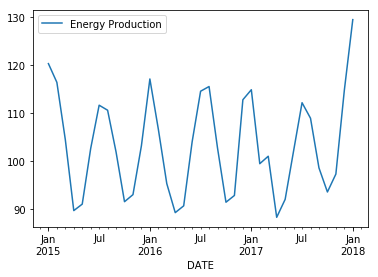

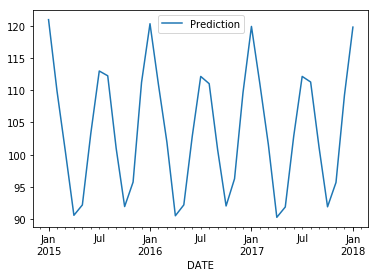

In [26]:
test.plot()
future_forecast.plot()

In [27]:
test.head()


,Energy Production
DATE,
2015-01-01,120.2696
2015-02-01,116.3788
2015-03-01,104.4706
2015-04-01,89.7461
2015-05-01,91.0930


In [28]:
future_forecast.head()

,Prediction
DATE,
2015-01-01,120.957455
2015-02-01,109.886814
2015-03-01,100.389105
2015-04-01,90.574055
2015-05-01,92.181339


In [29]:
result = test.merge(future_forecast, left_index=True,right_index=True, how='outer')

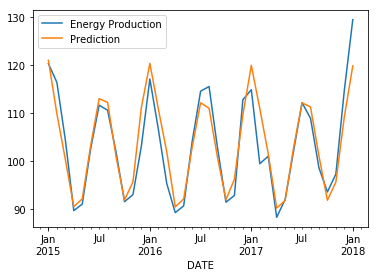

In [30]:
result.plot()